# Introduction

This is a very simplified demo that I made to have some data for an article I wrote. The goal is to:

* Compare prediction models with uplift models
* Optimize allocation of treatments
* Build a gui with some levers

I do this by imagining a scenario. Your company has three products with the innovative names of A, B and C. Each customer can have one, two or three products. Your goal is to increase the value (profits) of the existing customers. One approach to solve this problem is to increase the convergence, in other words, increase the number of products that the customers have. You have created a couple of different offers and now we are ready for the big question. Which customer should you communicate these offers with?

It is not:

* A complete guide on how to build, evaluate and run uplift models in a real world scenario

The focus of the demo would have been shifted completely if the goal was to incorporate all of my lessons learned from uplift models. If you are interested in that, then connect with me on linkedin www.linkedin.com/in/olalindeberg. I have left some questions in the comments as well. Feel free to think about them :)  

# Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.calibration import CalibratedClassifierCV
from pulp import LpMaximize, LpProblem, LpVariable, lpSum
import ipywidgets as widgets
from IPython.display import display

# Data generation

In [2]:
def set_random_prod_columns(sum_prod):
    # Initialize the output with all 0s
    result = [0, 0, 0]
    
    if sum_prod == 1:
        # Randomly choose one index to be 1
        idx = np.random.choice([0, 1, 2])  # Randomly choose an index: 0 for prod_a, 1 for prod_b, 2 for prod_c
        result[idx] = 1  # Set the chosen index to 1
    elif sum_prod == 2:
        # Randomly choose two indices to be 1
        indices = np.random.choice([0, 1, 2], 2, replace=False)  # Randomly select two indices
        for idx in indices:
            result[idx] = 1  # Set the chosen indices to 1
    
    # Return the result as a pandas Series, matching the column names
    return pd.Series(result, index=['prod_a', 'prod_b', 'prod_c'])

def target_prob(tenure, treatment, sum_prod):
    # General
    target_prob = np.sin(np.log(tenure))*treatment + (1/sum_prod * treatment) + np.random.normal(0, 0.2)
    target_prob = np.where(treatment==0, 0.1*tenure + target_prob, target_prob)    
    return target_prob

In [3]:
# I am making up the data and the feature names does not have any meaning. 
# Different target probabilities  for treated/control groups
# Note: data is included with 100k customers, which you can use.

n = 100000
df = pd.DataFrame()
rng = np.random.default_rng()

# Usage and tenure
df['tenure'] = rng.triangular(1, 10, 24, n)
df['usage'] = df['tenure'].apply(lambda x: np.sin(-np.log(x)) + np.random.normal(0, 0.05))
df['usage']  = (df.usage - df.usage.min()) / (df.usage.max() - df.usage.min())

#Products
prob_tenure = (df.tenure - df.tenure.min()) / (df.tenure.max() - df.tenure.min())
df['sum_prod'] = np.random.binomial(1, prob_tenure) + 1 
df[['prod_a', 'prod_b', 'prod_c']] = df['sum_prod'].apply(set_random_prod_columns)

In [4]:
# Generate treatment for each product
# Higher probability of treatment when having higher usage. 
# Note: Some of these outcomes are not valid, as we would not treat a customer that already have a product. 
# Q: When not having randomly assigned treatments, what can you do?
prod_list = ['prod_a', 'prod_b', 'prod_c']

for prod in prod_list:
    
    df[f'treatment_{prod}'] = np.random.binomial(1, df.usage)
    df[f'cf_treatment_{prod}'] = np.where(df[f'treatment_{prod}']==1, 0, 1)
    

# Create target with some slight variation depending on product type
for prod in prod_list:
    df[f'target_prob_{prod}'] = df.apply(lambda row: target_prob(row['tenure'], 
                                                                 row[f'treatment_{prod}'], 
                                                                 row['sum_prod']), 
                                                                 axis=1
                                        )
    df[f'target_prob_{prod}'] = np.where(df.prod_a==1,
                                 df[f'target_prob_{prod}'] + 0.5 * df.usage + 0.1 * df.tenure,
                        np.where(df.prod_b==1,
                                 df[f'target_prob_{prod}'] + 0.2 * df.usage - 0.1 * df.tenure,
                        np.where(df.prod_c==1,
                                 df[f'target_prob_{prod}'] - 0.1 * df.usage - 0.3 * df.tenure,                             
                                 df[f'target_prob_{prod}']
                                )
                            )
                        )
    df[f'target_prob_{prod}'] = (
                                (df[f'target_prob_{prod}'] - df[f'target_prob_{prod}'].min()) / 
                                (df[f'target_prob_{prod}'].max() - df[f'target_prob_{prod}'].min())
                                )
    
    df[f'target_{prod}'] = np.random.binomial(1, df[f'target_prob_{prod}'])
    

# Create counterfactual target with some slight variation depending on product type
for prod in prod_list:
    df[f'cf_target_prob_{prod}'] = df.apply(lambda row: target_prob(row['tenure'], 
                                                                 row[f'cf_treatment_{prod}'], 
                                                                 row['sum_prod']), 
                                                                 axis=1
                                        )
    df[f'cf_target_prob_{prod}'] = np.where(df.prod_a==1,
                                 df[f'cf_target_prob_{prod}'] + 0.5 * df.usage + 0.1 * df.tenure,
                        np.where(df.prod_b==1,
                                 df[f'cf_target_prob_{prod}'] + 0.2 * df.usage - 0.1 * df.tenure,
                        np.where(df.prod_c==1,
                                 df[f'cf_target_prob_{prod}'] - 0.1 * df.usage - 0.3 * df.tenure,                             
                                 df[f'cf_target_prob_{prod}']
                                )
                            )
                        )
    df[f'cf_target_prob_{prod}'] = (
                                    (df[f'cf_target_prob_{prod}'] - df[f'cf_target_prob_{prod}'].min()) / 
                                    (df[f'cf_target_prob_{prod}'].max() - df[f'cf_target_prob_{prod}'].min())
                                    )
    
    df[f'cf_target_{prod}'] = np.random.binomial(1, df[f'cf_target_prob_{prod}'])


In [5]:
df.head()

,tenure,usage,sum_prod,prod_a,prod_b,prod_c,treatment_prod_a,cf_treatment_prod_a,treatment_prod_b,cf_treatment_prod_b,...,target_prob_prod_b,target_prod_b,target_prob_prod_c,target_prod_c,cf_target_prob_prod_a,cf_target_prod_a,cf_target_prob_prod_b,cf_target_prod_b,cf_target_prob_prod_c,cf_target_prod_c
0,8.095356,0.212334,1,0,0,1,0,1,0,1,...,0.398332,1,0.510648,1,0.449504,0,0.469153,1,0.376739,1
1,7.407401,0.194928,1,0,0,1,0,1,0,1,...,0.425212,0,0.409328,0,0.486753,1,0.494270,1,0.479995,1
2,10.815416,0.465003,2,0,1,1,0,1,0,1,...,0.525446,0,0.550763,0,0.539686,1,0.541369,1,0.515504,1
3,10.562376,0.329440,1,1,0,0,1,0,0,1,...,0.731473,1,0.750579,1,0.687397,0,0.759023,0,0.742849,1
4,2.380315,0.247759,1,0,0,1,1,0,0,1,...,0.503771,0,0.490316,0,0.435610,0,0.575684,1,0.599731,1


In [6]:
notebook_dir = os.getcwd()
data_dir = os.path.join(notebook_dir, 'data')
os.makedirs(data_dir, exist_ok=True) 
file_path = os.path.join(data_dir, 'demo_data100k.csv')
df.to_csv(file_path, index=False)
#df = pd.read_csv(file_path)

## Visualization

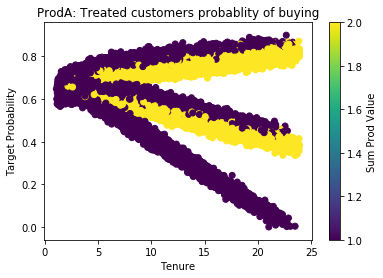

In [7]:
# Vizualisation of treated customers for product a
mask_tr = (df.treatment_prod_a==1)
scatter = plt.scatter(df[mask_tr]['tenure'], 
                      df[mask_tr]['target_prob_prod_a'], 
                      c=df[mask_tr]['sum_prod'], 
                      cmap='viridis', 
                      label='Data points'
                     )

# Add labels and title
plt.xlabel('Tenure')
plt.ylabel('Target Probability')
plt.title('ProdA: Treated customers probablity of buying')

# Add a colorbar to show the color mapping for the `sum_prod` values
plt.colorbar(scatter, label='Sum Prod Value')

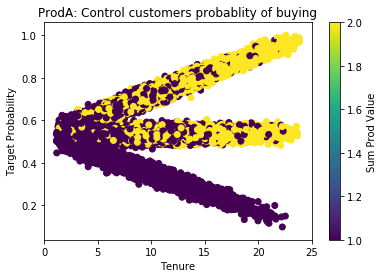

In [8]:
# Vizualisation of control customers for product a
mask_con = df.treatment_prod_a==0
scatter = plt.scatter(df[mask_con]['tenure'], 
                      df[mask_con]['target_prob_prod_a'], 
                      c=df[mask_con]['sum_prod'], 
                      cmap='viridis', 
                      label='Data points'
                     )

# Add labels and title
plt.xlabel('Tenure')
plt.ylabel('Target Probability')
plt.title('ProdA: Control customers probablity of buying')

# Add a colorbar to show the color mapping for the `sum_prod` values
plt.colorbar(scatter, label='Sum Prod Value')

# Modelling

## Setup before modelling

In [9]:
# Create a dict holding different datasets, some lists of features and so on.

features = ['tenure',
            'usage',
            'sum_prod',
           ]
treatment = ['treatment']
prod_list = ['prod_a', 'prod_b', 'prod_c']

data = {}

for prod in prod_list:

    filt = f'{prod}==0'

    # 70/20/10 split of train/val/test
    X_train, X_test, y_train, y_test = train_test_split(
                                                        df.query(filt)[features],
                                                        df.query(filt)[f'target_{prod}'],
                                                        test_size=0.1, 
                                                        random_state=5
                                                   )
    
    X_train, X_val, y_train, y_val = train_test_split(
                                                        X_train,
                                                        y_train,
                                                        test_size=0.22, 
                                                        random_state=5
                                                   )
    
    data[prod] = {}
    data[prod]['X_train'] = X_train
    data[prod]['X_test'] = X_test
    data[prod]['X_val'] = X_val
    data[prod]['y_train'] = y_train
    data[prod]['y_test'] = y_test
    data[prod]['y_val'] = y_val
    
# Cost and revenue for each product. 
# We will have no cost for impression (calling/email/text customer) but cost of conversion (discount/commission etc)
r_prod_a = 50 #revenue product a
c_prod_a = 5 #cost product a
r_prod_b = 60
c_prod_b = 10
r_prod_c = 45
c_prod_c = 4

## Prediction models

In [10]:
# Lets fit one prediction model for each cross-sell case
models = {}
models['pred'] = {}
scores = []

for prod in prod_list:
    
    pred_mdl = XGBClassifier(max_depth=3, gamma=2)
    calibrated_clf = CalibratedClassifierCV(pred_mdl, method='isotonic', cv=3)
    calibrated_clf.fit(data[prod]['X_train'], data[prod]['y_train'])
    
    models['pred'][f'clf_{prod}'] = calibrated_clf
    scores.append(f1_score(calibrated_clf.predict(data[prod]['X_val']), data[prod]['y_val']))

In [11]:
# Let's assume this is good enough for the f1 scores
print(np.mean(scores))
scores

0.6721754498610543


[0.45515934131027125, 0.7564702982499384, 0.8048967100229533]

## Uplift models

In [12]:
# Lets fit one prediction model for each cross-sell case
# In this case we train a t-learner
# Note: You should not use classification metrics for uplift models, but we will do it nevertheless
# Note: This is a very demo way of doing this...

models['uplift'] = {}
scores = []

for prod in prod_list:
    X_train_0 = data[prod]['X_train'][data[prod]['X_train'].index.isin(df.query(f'treatment_{prod}==0').index)]
    y_train_0 = data[prod]['y_train'][data[prod]['y_train'].index.isin(df.query(f'treatment_{prod}==0').index)]
    X_train_1 = data[prod]['X_train'][data[prod]['X_train'].index.isin(df.query(f'treatment_{prod}==1').index)]
    y_train_1 = data[prod]['y_train'][data[prod]['y_train'].index.isin(df.query(f'treatment_{prod}==1').index)]
    X_val_0 = data[prod]['X_val'][data[prod]['X_val'].index.isin(df.query(f'treatment_{prod}==0').index)]
    y_val_0 = data[prod]['y_val'][data[prod]['y_val'].index.isin(df.query(f'treatment_{prod}==0').index)]
    X_val_1 = data[prod]['X_val'][data[prod]['X_val'].index.isin(df.query(f'treatment_{prod}==1').index)]
    y_val_1 = data[prod]['y_val'][data[prod]['y_val'].index.isin(df.query(f'treatment_{prod}==1').index)]
    
    # Fit models
    pred_mdl = XGBClassifier(max_depth=3, gamma=2)
    calibrated_clf_0 = CalibratedClassifierCV(pred_mdl, method='isotonic', cv=3)
    calibrated_clf_0.fit(X_train_0, y_train_0)
    calibrated_clf_1 = CalibratedClassifierCV(pred_mdl, method='isotonic', cv=3)
    calibrated_clf_1.fit(X_train_1, y_train_1)
    
    #Save models
    models['uplift'][f'clf_{prod}_0'] = calibrated_clf_0
    scores.append(f1_score(calibrated_clf_0.predict(X_val_0), y_val_0))
    models['uplift'][f'clf_{prod}_1'] = calibrated_clf_1
    scores.append(f1_score(calibrated_clf_1.predict(X_val_1), y_val_1))        

In [13]:
print(np.mean(scores))
scores

0.6716390918779274


[0.3826508146191105,
 0.5071306332002281,
 0.7357727791023116,
 0.7862666254253015,
 0.7887598790125867,
 0.8292538199080255]

# Inference

## Estimate value from prediction models

In [14]:
# Q: What assumptions do we make with this type of expected value?
def value_pred(prob, revenue, cost, use_cost=True):
    """A very simple way of calculating the estimated value. We assume zero impression cost and only conversion cost."""
    if use_cost==True:
        value = prob * (revenue - cost)
    else:
        value = prob * revenue
    return value

pred_value_a = value_pred(models['pred']['clf_prod_a'].predict_proba(data['prod_a']['X_test'])[:,1],
                         r_prod_a, 
                         c_prod_a
                        )
pred_value_b = value_pred(models['pred']['clf_prod_b'].predict_proba(data['prod_b']['X_test'])[:,1],
                         r_prod_b, 
                         c_prod_b
                        )
pred_value_c = value_pred(models['pred']['clf_prod_c'].predict_proba(data['prod_c']['X_test'])[:,1],
                         r_prod_c, 
                         c_prod_c
                        )

## Estimate value from uplift models

In [15]:
# For product a, both treatment and control
up_value_a_0 = value_pred(models['uplift']['clf_prod_a_0'].predict_proba(data['prod_a']['X_test'])[:,1],
                         r_prod_a, 
                         c_prod_a,
                         use_cost = False
                        )
up_value_a_1 = value_pred(models['uplift']['clf_prod_a_1'].predict_proba(data['prod_a']['X_test'])[:,1],
                         r_prod_a, 
                         c_prod_a
                        )

# For product b, both treatment and control
up_value_b_0 = value_pred(models['uplift']['clf_prod_b_0'].predict_proba(data['prod_b']['X_test'])[:,1],
                         r_prod_b, 
                         c_prod_b,
                         use_cost = False
                        )
up_value_b_1 = value_pred(models['uplift']['clf_prod_b_1'].predict_proba(data['prod_b']['X_test'])[:,1],
                         r_prod_b, 
                         c_prod_b
                        )


# For product c, both treatment and control
up_value_c_0 = value_pred(models['uplift']['clf_prod_c_0'].predict_proba(data['prod_c']['X_test'])[:,1],
                         r_prod_c, 
                         c_prod_c,
                         use_cost = False
                        )
up_value_c_1 = value_pred(models['uplift']['clf_prod_c_1'].predict_proba(data['prod_c']['X_test'])[:,1],
                         r_prod_c, 
                         c_prod_c
                        )

## Oracle value

In [16]:
# Since we have the actual probabilities, we can use these to calculate the real value of different treatments 
#Q: How would you evaluate the and estimate impact in real world? 

df_test_a = df[df.index.isin(data['prod_a']['X_test'].index)].copy()
df_test_b = df[df.index.isin(data['prod_b']['X_test'].index)].copy()
df_test_c = df[df.index.isin(data['prod_c']['X_test'].index)].copy()

prob_a_treat = np.where(df_test_a.treatment_prod_a ==1, df_test_a.target_prob_prod_a, df_test_a.cf_target_prob_prod_a)
prob_a_control = np.where(df_test_a.treatment_prod_a ==0, df_test_a.target_prob_prod_a, df_test_a.cf_target_prob_prod_a)
or_value_a_0 = prob_a_control  * r_prod_a 
or_value_a_1 = prob_a_treat  * (r_prod_a - c_prod_a)

prob_b_treat = np.where(df_test_b.treatment_prod_b ==1, df_test_b.target_prob_prod_b, df_test_b.cf_target_prob_prod_b)
prob_b_control = np.where(df_test_b.treatment_prod_b ==0, df_test_b.target_prob_prod_b, df_test_b.cf_target_prob_prod_b)
or_value_b_0 = prob_b_control  * r_prod_b 
or_value_b_1 = prob_b_treat  * (r_prod_b - c_prod_b)

prob_c_treat = np.where(df_test_c.treatment_prod_a ==1, df_test_c.target_prob_prod_c, df_test_c.cf_target_prob_prod_c)
prob_c_control = np.where(df_test_c.treatment_prod_c ==0, df_test_c.target_prob_prod_c, df_test_c.cf_target_prob_prod_c)
or_value_c_0 = prob_c_control  * r_prod_c 
or_value_c_1 = prob_c_treat  * (r_prod_c - c_prod_c)

## Final inference table

In [17]:
# Let's create one table with all customers

df_test_a['pr_value_a'] = pred_value_a
df_test_a['up_value_a_0'] = up_value_a_0
df_test_a['up_value_a_1'] = up_value_a_1
df_test_a['or_value_a_0'] = or_value_a_0
df_test_a['or_value_a_1'] = or_value_a_1

df_test_b['pr_value_b'] = pred_value_b
df_test_b['up_value_b_0'] = up_value_b_0
df_test_b['up_value_b_1'] = up_value_b_1
df_test_b['or_value_b_0'] = or_value_b_0
df_test_b['or_value_b_1'] = or_value_b_1

df_test_c['pr_value_c'] = pred_value_c
df_test_c['up_value_c_0'] = up_value_c_0
df_test_c['up_value_c_1'] = up_value_c_1
df_test_c['or_value_c_0'] = or_value_c_0
df_test_c['or_value_c_1'] = or_value_c_1

df_inf = pd.concat([df_test_a[['pr_value_a', 'up_value_a_0', 'up_value_a_1', 'or_value_a_0', 'or_value_a_1']], 
                    df_test_b[['pr_value_b', 'up_value_b_0', 'up_value_b_1', 'or_value_b_0', 'or_value_b_1']], 
                    df_test_c[['pr_value_c', 'up_value_c_0', 'up_value_c_1', 'or_value_c_0', 'or_value_c_1']]], axis=1)

# Value optimization

In [18]:
def optimize_assignment(df, df_oracle, cons, cons_cols, penalty_factor):
    """
    Optimize assignment of values to maximize a sum with constraints.
    
    This function solves an optimization problem where the goal is to maximize the sum 
    of selected values from a given DataFrame `df`, while satisfying row and column constraints 
    with optional slack variables to allow for flexibility.
    
    Parameters:
        df (pd.DataFrame): A DataFrame containing the values to optimize over. 
            Invalid entries (e.g., NaN or -1000) are excluded from selection.
        df_oracle (pd.DataFrame): A reference DataFrame containing the true values 
            associated with the selections for evaluation purposes.
        cons (list[int]): A list of minimum values (constraints) for each target column.
        cons_cols (list[int]): A list of column indices corresponding to the constraints.
        penalty_factor (float): The penalty applied to slack variables in the objective function. 
            Larger values reduce deviations from the constraints.
    
    Returns:
        uplift_max (float): The maximum sum of the selected values from `df_oracle` 
            achieved under the constraints.
        selected_sums (list[int]): A list of the number of selections made per column 
            specified in `cons_cols`.
    
    Raises:
        AssertionError: If a selected value from `df_oracle` is NaN, indicating a potential error 
            in the optimization logic or input data.
        
    Notes:
        - Each row in the DataFrame must have exactly one selected value from valid columns.
        - Constraints are enforced with slack variables, allowing deviations at the cost of 
          a penalty proportional to `penalty_factor`.
        - The function uses the PuLP library for linear programming and assumes that the input 
          data and constraints are well-prepared.
    
    Example:
        df = pd.DataFrame([[1, 2, np.nan], [3, 4, 5]])
        df_oracle = pd.DataFrame([[10, 20, np.nan], [30, 40, 50]])
        cons = [1, 1, 0]
        cons_cols = [0, 1, 2]
        penalty_factor = 100
    
        uplift_max, selected_sums = optimize_assignment(df, df_oracle, cons, cons_cols, penalty_factor)
"""

    
    num_rows = len(df)
    
    # Determine valid columns for each row
    valid_columns = [
        [j for j, val in enumerate(row) if not pd.isna(val) and val != -1000]
        for row in df.itertuples(index=False)
    ]

    # Create the problem
    problem = LpProblem("Maximize_Sum_with_slack", LpMaximize)
    
    # Create decision variables for valid values only
    x = [
        [LpVariable(f"x_{i}_{j}", cat="Binary") if j in valid_columns[i] else None
         for j in range(df.shape[1])]
        for i in range(num_rows)
    ]
    
    # Slack Variables (for elastic constraints)
    slack_vars = [LpVariable(f"slack_{k}", lowBound=0, cat="Continuous") for k in range(len(cons))]

    # Objective function: Maximize the sum of selected values minus penalties
    problem += lpSum(
        df.iloc[i, j] * x[i][j]
        for i in range(num_rows) for j in valid_columns[i]
    ) - penalty_factor * lpSum(slack_vars)
    
    # Constraints: Only one value per row
    for i in range(num_rows):
        problem += lpSum(x[i][j] for j in valid_columns[i]) == 1
    
    # Elastic constraints
    for k, col in enumerate(cons_cols):
        problem += lpSum(
            x[i][col] for i in range(num_rows) 
            if x[i][col] is not None
        ) >= cons[k] - slack_vars[k]
    
    # Solve the problem
    problem.solve()
    #print(f"Solver status: {problem.status}")

    # Collect selected indices
    selected_indices = [
        (i, j) for i in range(num_rows) for j in valid_columns[i]
        if x[i][j] is not None and x[i][j].value() == 1
    ]

    # Calculate the true value from df_oracle
    selected_values = [(i, j, df_oracle.iloc[i, j]) for i, j in selected_indices]
    assert all(not pd.isna(value) for _, _, value in selected_values), "NaN selected in output!"

    # Calculate the sum of selected values
    uplift_max = sum(value for _, _, value in selected_values)

    # Calculate selected sums for each constraint
    selected_sums = [0] * len(cons_cols)
    for i, j in selected_indices:
        if j in cons_cols:
            col_index = cons_cols.index(j)
            selected_sums[col_index] += 1
    
    return uplift_max, selected_sums


In [19]:
# Prediction model

# Constraints - in this case nothing
min_rows_a = 0 # Minimum selection for each row
min_rows_b = 0  # Minimum selection for each row
min_rows_c = 0  # Minimum selection for each row

df_pred = df_inf[['pr_value_a', 'pr_value_b', 'pr_value_c']].reset_index(drop=True).copy()
df_pred = df_pred.fillna(-1000) # A negative number to avoid issues with selection of unelegible customers
df_oracle_pred = df_inf[['or_value_a_1','or_value_b_1', 'or_value_c_1']].reset_index(drop=True).copy()


con_list_pred = [min_rows_a, min_rows_b, min_rows_c]
treat_cols_pred = [0, 1, 2]
nr_pred_max, pred_treat_assignment = optimize_assignment(df_pred, 
                                                         df_oracle_pred, 
                                                         con_list_pred, 
                                                         treat_cols_pred, 
                                                         penalty_factor=100
                                                        )

In [21]:
# Uplift model

# Constraints - in this case nothing
min_rows_a = 0 # Minimum selection for each row
min_rows_b = 0  # Minimum selection for each row
min_rows_c = 0  # Minimum selection for each row

df_up = df_inf[['up_value_a_0', 
                  'up_value_a_1', 
                  'up_value_b_0',
                  'up_value_b_1',
                  'up_value_c_0',
                  'up_value_c_1',
                 ]
                ].copy()
df_up = df_up.fillna(-1000) # A very low number to avoid issues with selection of unelegible customers
df_oracle_up = df_inf[['or_value_a_0',
                    'or_value_a_1', 
                    'or_value_b_0',
                    'or_value_b_1',
                    'or_value_c_0',
                    'or_value_c_1'
                   ]
                  ].copy()


con_list_up = [min_rows_a, min_rows_b, min_rows_c]
treat_cols_up = [1, 3, 5]
nr_up_max, up_treat_assignment = optimize_assignment(df_up, 
                                                     df_oracle_up, 
                                                     con_list_up, 
                                                     treat_cols_up, 
                                                     penalty_factor=100
                                                    )

In [22]:
# Oracle model
# Constraints - in this case nothing
min_rows_a = 0 # Minimum selection for each row
min_rows_b = 0  # Minimum selection for each row
min_rows_c = 0  # Minimum selection for each row

df_oracle = df_inf[['or_value_a_0', 
                  'or_value_a_1', 
                  'or_value_b_0',
                  'or_value_b_1',
                  'or_value_c_0',
                  'or_value_c_1',
                 ]
                ].copy()
df_oracle = df_oracle.fillna(-1000) # A very low number to avoid issues with selection of unelegible customers

con_list = [min_rows_a, min_rows_b, min_rows_c]
treat_cols = [1, 3, 5]
nr_or_max, or_treat_assignment = optimize_assignment(df_oracle, df_oracle, con_list, treat_cols, penalty_factor=100)

In [23]:
print(f'Estimated value using prediction models for treatment assignment: {nr_pred_max}')
print(f'Estimated value using uplift models for treatment assignment: {nr_up_max}')
print(f'Estimated value using optimal/oracle for treatment assignment: {nr_or_max}')

Estimated value using prediction models for treatment assignment: 404575.5477435393
Estimated value using uplift models for treatment assignment: 431002.32384025084
Estimated value using optimal/oracle for treatment assignment: 450286.61298021884


# Simple GUI for decision making

In [25]:
#If you are looking for inspiration on how to build a GUI, then this might not be the place you for you ;)

# Input Widgets
header = widgets.HTML(value="<h1 style='color: navy;'>Target Number of Customers Contacted</h1>")
input_a = widgets.IntText(value=5, description="Product A:", style={'description_width': 'initial'})
input_b = widgets.IntText(value=3, description="Product B:", style={'description_width': 'initial'})
input_c = widgets.IntText(value=2, description="Product C:", style={'description_width': 'initial'})
button = widgets.Button(
    description="Estimate Impact",
    style={'button_color': 'gray', 'font_weight': 'bold'},
    layout=widgets.Layout(width="200px", margin="10px 0")
)

# Output Widgets
output_header = widgets.HTML(value="<h1 style='color: navy;'>Estimated Results</h1>")
profit_header = widgets.HTML(value="<h3 style='color: dimgray;'>Profits</h3>")
pred_max_label = widgets.HTML(value="<b style='color: navy;'>Prediction Model:</b>")
pred_max_output = widgets.Label(value="")

uplift_max_label = widgets.HTML(value="<b style='color: navy;'>Uplift Model:</b>")
uplift_max_output = widgets.Label(value="")

diff_label = widgets.HTML(value="<b style='color: darkred;'>Difference (%):</b>")
diff_output = widgets.Label(value="")

# Customer results widgets
estimate_cust_contact_label = widgets.HTML(value="<h3 style='color: dimgray;'>Customers Contacted</h3>")
pr_output_a = widgets.Label(value="Product A", layout=widgets.Layout(width="80px"))
pr_results_a = widgets.Label(value="")
pr_output_b = widgets.Label(value="Product B", layout=widgets.Layout(width="80px"))
pr_results_b = widgets.Label(value="")
pr_output_c = widgets.Label(value="Product C", layout=widgets.Layout(width="80px"))
pr_results_c = widgets.Label(value="")

up_output_a = widgets.Label(value="Product A", layout=widgets.Layout(width="80px"))
up_results_a = widgets.Label(value="")
up_output_b = widgets.Label(value="Product B", layout=widgets.Layout(width="80px"))
up_results_b = widgets.Label(value="")
up_output_c = widgets.Label(value="Product C", layout=widgets.Layout(width="80px"))
up_results_c = widgets.Label(value="")

# No constraints
no_constraints_header = widgets.HTML(value="<h3 style='color: dimgray;'>Baseline: No Constraints</h3>")
no_pred_max_output = widgets.Label(value="")
no_uplift_max_output = widgets.Label(value="")
no_diff_output = widgets.Label(value="")

# Button Click Event
def on_button_click(b):
    cons = [input_a.value, input_b.value, input_c.value]
    pred_max, pr_selected_sums = optimize_assignment(df_pred, 
                                                      df_oracle_pred, 
                                                      cons, 
                                                      treat_cols_pred, 
                                                      penalty_factor=100
                                                     )
    uplift_max, up_selected_sums = optimize_assignment(df_up, 
                                                       df_oracle_up, 
                                                       cons, 
                                                       treat_cols_up, 
                                                       penalty_factor=100
                                                      )
    
    
    
    # Update output widgets
    pred_max_output.value = f"${pred_max:.2f}"
    pr_results_a.value = str(pr_selected_sums[0])
    pr_results_b.value = str(pr_selected_sums[1])
    pr_results_c.value = str(pr_selected_sums[2])
    
    uplift_max_output.value = f"${uplift_max:.2f}"
    up_results_a.value = str(up_selected_sums[0])
    up_results_b.value = str(up_selected_sums[1])
    up_results_c.value = str(up_selected_sums[2])
    
    diff_output.value = calculate_percentage_change(uplift_max, pred_max)
    
    # No restrictions
    no_pred_max_output.value = f"${nr_pred_max:.2f}"
    no_uplift_max_output.value = f"${nr_up_max:.2f}"
    no_diff_output.value = calculate_percentage_change(nr_up_max, nr_pred_max)

button.on_click(on_button_click)

# Arrange layout for proper vertical alignment
profit_section = widgets.VBox([
    widgets.HBox([pred_max_label, pred_max_output], layout=widgets.Layout(align_items="center")),
    widgets.HBox([uplift_max_label, uplift_max_output], layout=widgets.Layout(align_items="center")),
    widgets.HBox([diff_label, diff_output], layout=widgets.Layout(align_items="center"))
], layout=widgets.Layout(border="solid 3px lightgray", padding="1px", margin="1px 0"))

customer_contact_section = widgets.VBox([
    widgets.HTML(value="<b style='color: navy;'>Prediction Model:</b>"),
    widgets.HBox([pr_output_a, pr_results_a]),
    widgets.HBox([pr_output_b, pr_results_b]),
    widgets.HBox([pr_output_c, pr_results_c]),
    widgets.HTML(value="<b style='color: navy;'>Uplift Model:</b>"),
    widgets.HBox([up_output_a, up_results_a]),
    widgets.HBox([up_output_b, up_results_b]),
    widgets.HBox([up_output_c, up_results_c])
], layout=widgets.Layout(border="solid 3px lightgray", padding="1px", margin="1px 0"))

no_constraints_section = widgets.VBox([
    widgets.HBox([widgets.HTML(value="<b>Prediction Model:</b>"), no_pred_max_output], layout=widgets.Layout(align_items="center")),
    widgets.HBox([widgets.HTML(value="<b>Uplift Model:</b>"), no_uplift_max_output], layout=widgets.Layout(align_items="center")),
    widgets.HBox([widgets.HTML(value="<b>Difference (%):</b>"), no_diff_output], layout=widgets.Layout(align_items="center"))
], layout=widgets.Layout(border="solid 3px lightgray", padding="1px", margin="1px 0"))

output_section = widgets.VBox([
    output_header, 
    profit_header, 
    profit_section, 
    estimate_cust_contact_label, 
    customer_contact_section,
    no_constraints_header,
    no_constraints_section
])

# Display the GUI
display(widgets.VBox([header, input_a, input_b, input_c, button]), output_section)
